In [1]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')


In [3]:
# Avoid OOM error by setting GPU Memory Consumption Growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2
import imghdr

C:\Users\syzmon\AppData\Local\Temp\ipykernel_12792\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
 

In [6]:
os.listdir(data_dir)

['happy_people', 'sad_people']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)

In [8]:
# Load Data
data = tf.keras.utils.image_dataset_from_directory('data')


Found 169 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()


In [10]:
batch = data_iterator.next()

In [11]:
batch[1].shape

(32,)

In [12]:
data = data.map(lambda x,y: (x/255.0 ,y)) #skalowanie w preprocesorze 


In [13]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()


In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
#build DL model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [17]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),

    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')

])

model.compile(
    'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [18]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs = 20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 2s/step - loss: 1.4682 - accuracy: 0.4844 - val_loss: 0.8131 - val_accuracy: 0.5625
Epoch 2/20
4/4 [==============================] - 10s 2s/step - loss: 0.7410 - accuracy: 0.5391 - val_loss: 0.6385 - val_accuracy: 0.5938
Epoch 3/20
4/4 [==============================] - 11s 2s/step - loss: 0.6852 - accuracy: 0.5312 - val_loss: 0.6464 - val_accuracy: 0.5625
Epoch 4/20
4/4 [==============================] - 10s 2s/step - loss: 0.6481 - accuracy: 0.7500 - val_loss: 0.6365 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 11s 2s/step - loss: 0.6133 - accuracy: 0.8203 - val_loss: 0.5574 - val_accuracy: 0.8438
Epoch 6/20
4/4 [==============================] - 14s 3s/step - loss: 0.5694 - accuracy: 0.7109 - val_loss: 0.5234 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 13s 3s/step - loss: 0.4990 - accuracy: 0.8203 - val_loss: 0.3624 - val_accuracy: 0.9062
Epoch 8/20
4/4 [==================

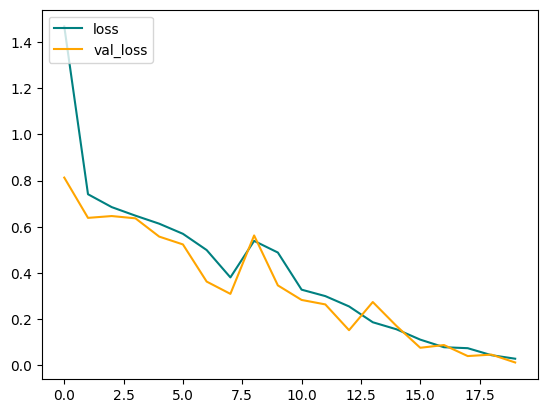

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
plt.legend(loc = "upper left")
plt.show()


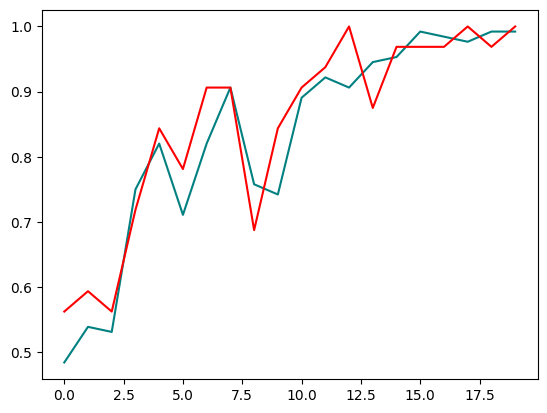

In [21]:
# plot accuracy
fit = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
plt.show()

In [50]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc= BinaryAccuracy()

In [51]:
len(test)

1

In [52]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


1/1 [==============================] - 0s 132ms/step
Precision:1.0,Recall:1.0, Accuracy:1.0


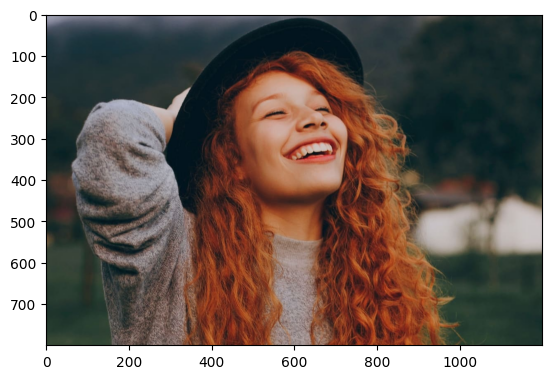

In [53]:
test_img = cv2.imread('s.jpg')
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.show()

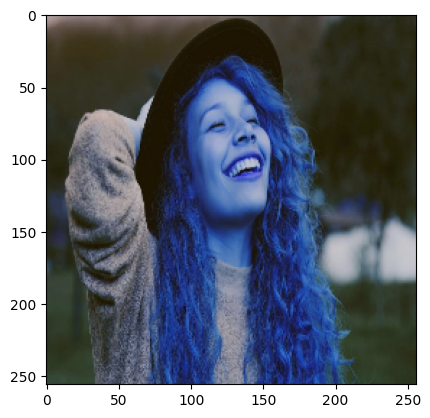

In [54]:
resizee = tf.image.resize(test_img, (256,256))
plt.imshow(resizee.numpy().astype(int))
plt.show()

In [56]:
np.expand_dims(resizee,0).shape

(1, 256, 256, 3)

In [60]:
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# plt.show()
yhat2 = model.predict(np.expand_dims(resizee/255.0,0))
if yhat2 > 0.5:
    print(": (")
else:
    print(": )")
yhat2

1/1 [==============================] - 0s 57ms/step
: (


array([[0.9956114]], dtype=float32)